In [1]:
using SparseArrays

using ReinforcementLearningCore, RLIntro, RLIntro.RandomWalk
using StatsBase, Plots

┌ Info: Precompiling ReinforcementLearningCore [de1b191a-4ae0-4afa-a27b-92d07f46b2d6]
└ @ Base loading.jl:1273
┌ Info: Precompiling RLIntro [02c1da58-b9a1-11e8-0212-f9611b8fe936]
└ @ Base loading.jl:1273


In [2]:
ACTIONS = collect(Iterators.flatten((-100:-1, 1:100)))
NS = 1002
NA = length(ACTIONS)

200

Here we define a group mapping preprocessor first.

The first and the last element will be grouped into another two separate group.

In [3]:
Base.@kwdef struct GroupMapping <: AbstractPreprocessor
    n::Int
    n_groups::Int
    n_per_group::Int=div(n, n_groups)
end

function (p::GroupMapping)(obs)
    x = get_state(obs)
    if x == 1
        res = 1
    elseif x == p.n
        res = p.n_groups + 2
    else
        res = div(x - 2, p.n_per_group) + 2
    end
    StateOverriddenObs(obs, res)
end

And then define a hook to calculate the count of each state.

In [4]:
struct CountStates <: AbstractHook
    counts::Vector{Int}
    CountStates(n) = new(zeros(Int, n))
end

(f::CountStates)(::PreActStage, agent, env, obs, action) = f.counts[get_state(observe(env.env))] += 1

In [5]:
env = RandomWalkEnv(N=NS, actions=ACTIONS)

RandomWalkEnv(1002, 501, 501, [-100, -99, -98, -97, -96, -95, -94, -93, -92, -91  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], -1.0, 1.0, DiscreteSpace{UnitRange{Int64}}(1:1002), DiscreteSpace{UnitRange{Int64}}(1:200))

In [6]:
observe(env)

(state = 501, terminal = false, reward = 0.0)

In [7]:
TRUE_STATE_VALUES = begin
    env = RandomWalkEnv(N=NS, actions=ACTIONS)
    agent = Agent(
        policy=VBasedPolicy(
            value_learner=TDLearner(
                approximator=TabularApproximator(n_state=NS),
                method=:SRS,
                optimizer=Descent(0.01)
                ),
            mapping=(obs,V) -> begin
                values = zeros(NA)
                values[rand(1:NA)] = 1.0
                values
            end
            ),
        trajectory=EpisodicCompactSARTSATrajectory()
    )
    run(agent, env, StopAfterEpisode(10^5))
    agent.policy.value_learner.approximator.table
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


1002-element Array{Float64,1}:
  0.0               
 -0.9051865848415822
 -0.9093253367598028
 -0.9115152201597078
 -0.9163966374837029
 -0.8935528871911314
 -0.9019137473809624
 -0.9055219376838884
 -0.9173078497738502
 -0.9074928093318804
 -0.8869029645902626
 -0.9009921416362758
 -0.8916554258480777
  ⋮                 
  0.8981535703096089
  0.892284758659177 
  0.896910684476593 
  0.9025079223978246
  0.8986249040986725
  0.8999159564925931
  0.8911617393349721
  0.9036429945246884
  0.9074151411224282
  0.9194481179361207
  0.9046479964732373
  0.0               

In [8]:
using Plots

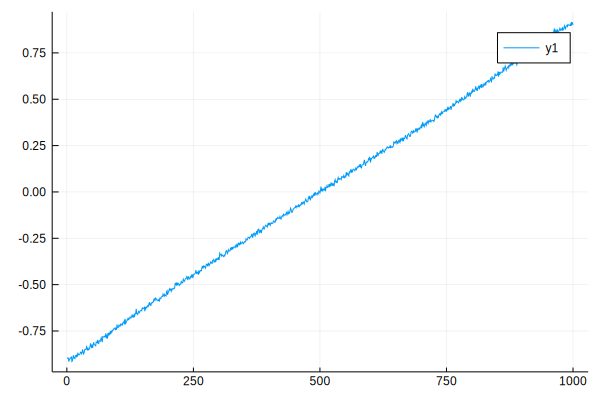

In [11]:
plot(TRUE_STATE_VALUES[2:end-1])

In [9]:
struct RecordRMS <: AbstractHook
    rms::Vector{Float64}
    RecordRMS() = new([])
end

function (f::RecordRMS)(::PostEpisodeStage, agent, env, obs)
    push!(f.rms, sqrt(mean((agent.policy.value_learner.approximator.(env.preprocessor.(2:(NS-1))) - TRUE_STATE_VALUES[2:end-1]).^2)))
end

In [10]:
n_groups = 10
env = WrappedEnv(
    env=RandomWalkEnv(N=NS, actions=ACTIONS),
    preprocessor=GroupMapping(n=NS, n_groups=n_groups)
    )

WrappedEnv{GroupMapping,RandomWalkEnv}(GroupMapping(1002, 10, 100), RandomWalkEnv(1002, 501, 501, [-100, -99, -98, -97, -96, -95, -94, -93, -92, -91  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], -1.0, 1.0, DiscreteSpace{UnitRange{Int64}}(1:1002), DiscreteSpace{UnitRange{Int64}}(1:200)))

In [23]:
agent = Agent(
    policy=VBasedPolicy(
        value_learner=MonteCarloLearner(
            approximator=TabularApproximator(n_state=n_groups+2),
            kind=EVERY_VISIT,  # this is very important!
            α=2e-5),
        mapping=(obs,V) -> begin
                values = zeros(NA)
                values[rand(1:NA)] = 1.0
                values
            end
        ),
    trajectory=EpisodicCompactSARTSATrajectory()
)

Agent{VBasedPolicy{MonteCarloLearner{RLIntro.EveryVisit,TabularApproximator{1,Array{Float64,1}},CachedSampleAvg{Float64},RLIntro.NoSampling},var"#20#21",EpsilonGreedyExplorer{:linear,Random.MersenneTwister}},EpisodicCompactSARTSATrajectory{Tuple{Int64,Int64,Float32,Bool,Int64,Int64},Tuple{Array{Float32,1},Array{Bool,1},Array{Int64,1},Array{Int64,1}}},ReinforcementLearningBase.DefaultPlayer}(VBasedPolicy{MonteCarloLearner{RLIntro.EveryVisit,TabularApproximator{1,Array{Float64,1}},CachedSampleAvg{Float64},RLIntro.NoSampling},var"#20#21",EpsilonGreedyExplorer{:linear,Random.MersenneTwister}}(MonteCarloLearner{RLIntro.EveryVisit,TabularApproximator{1,Array{Float64,1}},CachedSampleAvg{Float64},RLIntro.NoSampling}(TabularApproximator{1,Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), 1.0, 2.0e-5, CachedSampleAvg{Float64}(Dict{Float64,SampleAvg}())), var"#20#21"(), EpsilonGreedyExplorer{:linear,Random.MersenneTwister}(0.0, 1.0, 0, 0, 1, Random.MersenneTwister(U

In [24]:
hook=CountStates(NS)
run(agent, env, StopAfterEpisode(10^5),hook)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


CountStates([0, 1213, 1248, 1254, 1277, 1298, 1365, 1324, 1413, 1436  …  1350, 1265, 1319, 1284, 1261, 1272, 1307, 1232, 1243, 0])

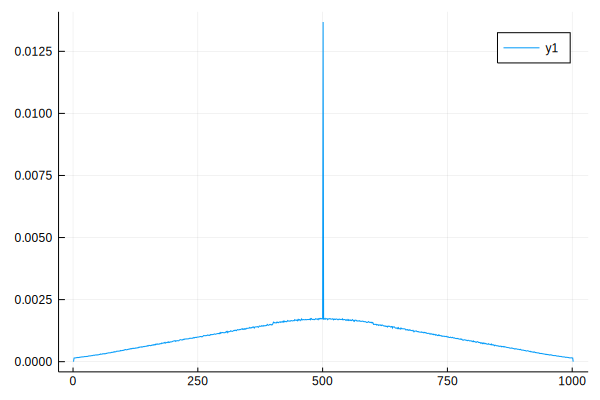

In [25]:
plot(hook.counts./sum(hook.counts))

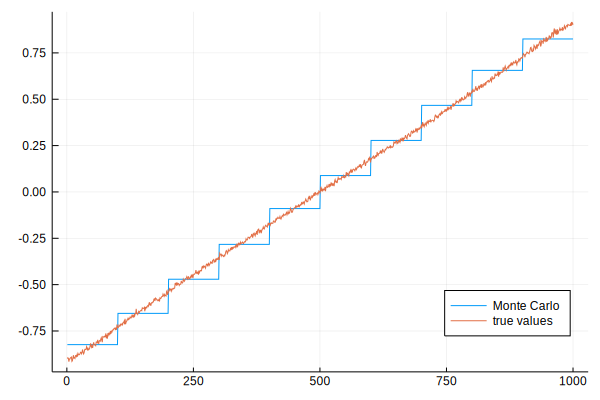

In [27]:
plot(agent.policy.value_learner.approximator.(env.preprocessor(s) for s in 2:NS-1),legend=:bottomright, label="Monte Carlo")
plot!(TRUE_STATE_VALUES[2:end-1], label="true values")

In [28]:
agent = Agent(
    policy=VBasedPolicy(
        value_learner=TDLearner(
                approximator=TabularApproximator(n_state=n_groups+2),
                method=:SRS,
                optimizer=Descent(2e-4)
                ),
        mapping=(obs,V) -> begin
                values = zeros(NA)
                values[rand(1:NA)] = 1.0
                values
            end
        ),
    trajectory=EpisodicCompactSARTSATrajectory()
)
run(agent, env, StopAfterEpisode(10^5))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


EmptyHook()

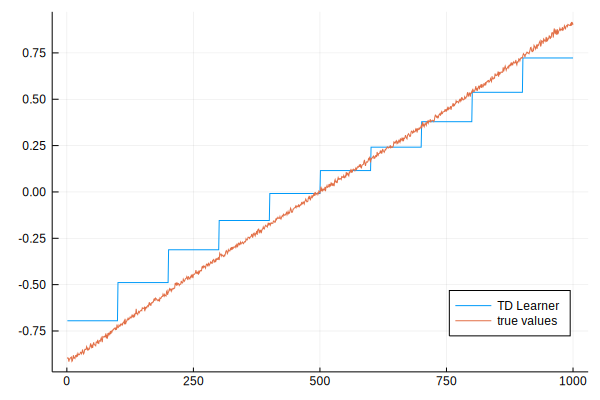

In [29]:
plot(agent.policy.value_learner.approximator.(env.preprocessor(s) for s in 2:NS-1),legend=:bottomright, label="TD Learner")
plot!(TRUE_STATE_VALUES[2:end-1], label="true values")

In [11]:
using StatsBase

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


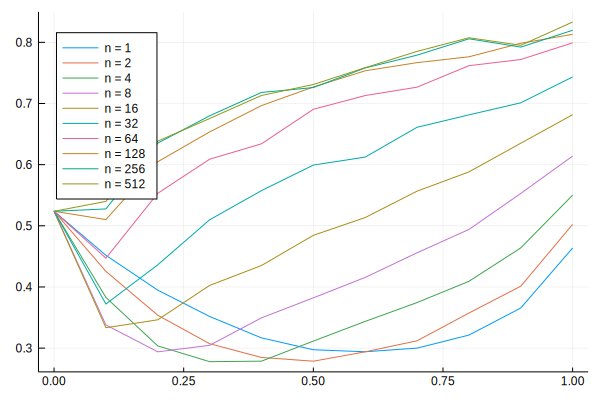

In [33]:
n_groups = 20
function run_once(n, α)
    env = WrappedEnv(
        env=RandomWalkEnv(N=NS, actions=ACTIONS),
        preprocessor=GroupMapping(n=NS, n_groups=n_groups)
        )
    agent = Agent(
        policy=VBasedPolicy(
            value_learner=TDLearner(
                approximator=TabularApproximator(n_state=n_groups+2),
                method=:SRS,
                optimizer=Descent(α),
                n=n
                ),
            mapping=(obs,V) -> begin
                    values = zeros(NA)
                    values[rand(1:NA)] = 1.0
                    values
                end
            ),
        trajectory=EpisodicCompactSARTSATrajectory()
    )

    hook = RecordRMS()
    run(agent, env, StopAfterEpisode(10),hook)
    mean(hook.rms)
end

A = 0:0.1:1

p = plot(legend=:topleft)
for n in [2^i for i in 0:9]
    plot!(p, A, mean([run_once(n, α) for α in A] for _ in 1:100), label="n = $n")
end
p

In [13]:
struct ScalePreprocessor <: AbstractPreprocessor
    scale::Float64
end

(p::ScalePreprocessor)(x::Number) = p.scale * x

In [18]:
function run_once_MC(preprocessor, order, α)
    env = WrappedEnv(
        env=RandomWalkEnv(N=NS, actions=ACTIONS),
        preprocessor=preprocessor
        )
    
    agent = Agent(
        policy=VBasedPolicy(
            value_learner=MonteCarloLearner(
                approximator=LinearVApproximator(zeros(order+1)),
                α=α,
                kind=EVERY_VISIT,
                returns = CachedSampleAvg{Vector{Float64}}(),
                ),
            mapping=(obs,V) -> begin
                    values = zeros(NA)
                    values[rand(1:NA)] = 1.0
                    values
                end
            ),
        trajectory=EpisodicCompactSARTSATrajectory(;state_type=Vector{Float64})
    )

    hook=RecordRMS()
    run(agent, env, StopAfterEpisode(5000;is_show_progress=false),hook)
    hook.rms
end

run_once_MC (generic function with 1 method)

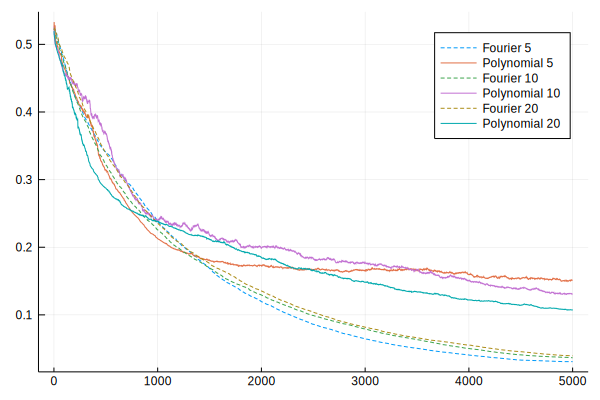

In [19]:
p = plot(legend=:topright)
for order in [5, 10, 20]
    plot!(p, mean(run_once_MC(ComposedPreprocessor(ScalePreprocessor(1/NS), FourierPreprocessor(order)), order, 0.00005) for _ in 1:1), label="Fourier $order", linestyle=:dash)
    plot!(p, mean(run_once_MC(ComposedPreprocessor(ScalePreprocessor(1/NS), PolynomialPreprocessor(order)), order, 0.0001) for _ in 1:1), label="Polynomial $order", linestyle=:solid)
end
p

In [26]:
function run_once_MC(preprocessor, α, V)
    env = WrappedEnv(
        env=RandomWalkEnv(N=NS, actions=ACTIONS),
        preprocessor=preprocessor
        )
    
    agent = Agent(
        policy=VBasedPolicy(
            value_learner=MonteCarloLearner(
                approximator=LinearVApproximator(V),
                α=α,
                kind=EVERY_VISIT,
                returns = CachedSampleAvg{SparseMatrixCSC{Float64,Int64}}(),
                ),
            mapping=(obs,V) -> begin
                    values = zeros(NA)
                    values[rand(1:NA)] = 1.0
                    values
                end
            ),
        trajectory=EpisodicCompactSARTSATrajectory(;state_type=SparseMatrixCSC{Float64,Int64})
    )

    hook=RecordRMS()
    run(agent, env, StopAfterEpisode(10000;is_show_progress=false),hook)
    hook.rms
end

run_once_MC (generic function with 1 method)

In [27]:
struct ToSparseMatrixPreprocessor <: AbstractPreprocessor
    m::Int
    n::Int
end

(p::ToSparseMatrixPreprocessor)(xs::Vector{Int}) = sparse(xs, 1:length(xs), ones(length(xs)), p.m, p.n)

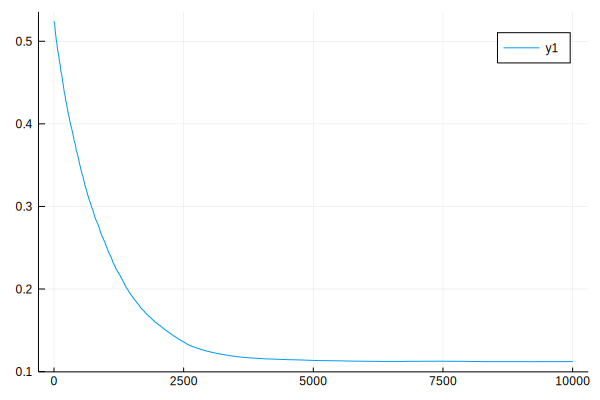

In [28]:
plot(run_once_MC(
    ComposedPreprocessor(
        TilingPreprocessor([Tiling((range(1-4*(i-1), step=200, length=7),)) for i in 1:1]),
        ToSparseMatrixPreprocessor(7, 1)
        ),
    1e-4/1,
    zeros(7,1)))

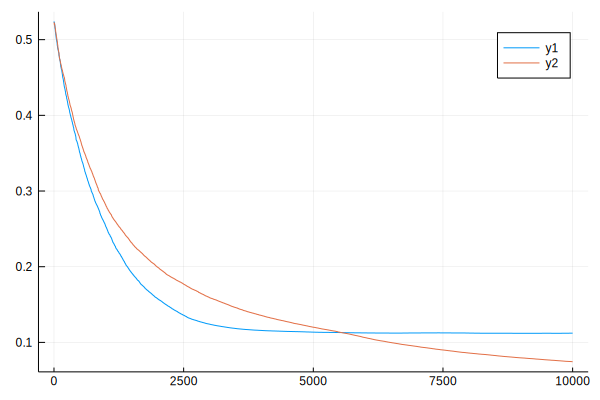

In [29]:
plot!(run_once_MC(
    ComposedPreprocessor(
        TilingPreprocessor([Tiling((range(1-4*(i-1), step=200, length=7),)) for i in 1:50]),
        ToSparseMatrixPreprocessor(7, 50)
        ),
    1e-4/50,
    zeros(7,50)))